In [1]:
import sys, os
os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 227, in <module>
    use(config.device)
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 99, in init_dev
    **args)
  File "pygpu\gpuarray.pyx", line 658, in pygpu.gpuarray.init
  Fil

Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  2
Compilation Done!


C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.46756e-12): result may not be accurate.
  rval = scipy.linalg.solve(A, b)


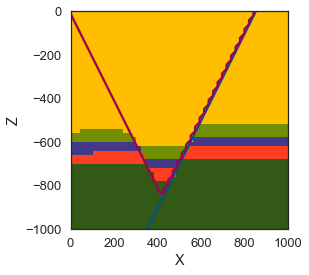

In [2]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [3]:
res = geo_model.grid.regular_grid.resolution
lb = np.round(geo_model.solutions.block_matrix[-1, 0, :]).astype(int)
fb = np.round(geo_model.solutions.block_matrix[:-1, 0, :]).astype(int)

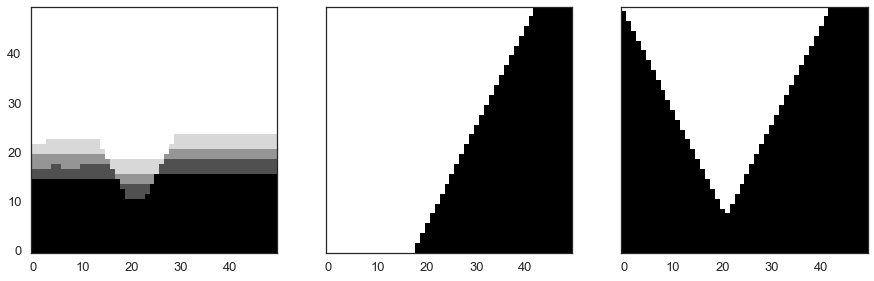

In [4]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, block in zip(axs, (lb, *fb)):
    ax.imshow(block.reshape(*res)[:, 24, :].T, origin="lower")

In [5]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
7,fault2,fault_series2,1,False,#015482,1
5,fault1,fault_series1,1,False,#9f0052,2
6,rock4,series1,1,False,#ffbe00,3
0,rock3,series1,2,False,#728f02,4
3,rock2,series1,3,False,#443988,5
1,rock1,series1,4,False,#ff3f20,6
4,basement,basement_series,1,True,#325916,7


In [6]:
geo_model.faults

,isFault,isFinite
fault_series2,True,False
fault_series1,True,False
series1,False,False
basement_series,False,False


### create unique labels

In [7]:
import logging
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

In [45]:
def lithblock_to_lb_fb(geo_model) -> tuple:
    """Serve flattened lithology id and fault blocks from solutions
    stored in given geomodel instance for topological analysis (i.e.
    rounded integer arrays).
    
    Args:
        geo_model (gp.core.model.Model): GemPy Model instance with 
            solutions.
    
    Returns:
        (tuple) of np.ndarray's containing the lithilogy id block
            and fault block stack.
    """
    lb = np.round(geo_model.solutions.block_matrix[-1, 0, :]).astype(int)
    fb = np.round(geo_model.solutions.block_matrix[:-1, 0, :]).astype(int)
    return lb, fb


def get_fault_ids(geo_model) -> np.array:
    """Get surface id's for all faults in given geomodel.
    
    Args:
        geo_model ():
        
    Returns:
        (np.array) of int surface id's.
    
    """
    isfault = np.isin(
        geo_model.surfaces.df.series, 
        geo_model.faults.df.index[geo_model.faults.df.isFault]
    )
    return geo_model.surfaces.df.id[isfault].values
    
    
def label(geo_model) -> np.ndarray:
    """Uniquely label geobodies in geomodel for topology analysis.
    
    Args:
        geo_model ():
    
    Returns:
        (np.ndarray) Uniquely labeled geomodel (flattened)
    """
    # get data
    lb, fb = lithblock_to_lb_fb(geo_model)
    fault_ids = get_fault_ids(geo_model)
    logging.debug(f"fault id's: {fault_ids}")
    # label lithologies
    lb_labels = lb # - lb.min() + 1
    logging.debug(f"lb labels: {np.unique(lb_labels)}")
    # label faults
    fb_labels = fb - fb.min(axis=1)[:, None]
    fb_labels = fb_labels * fault_ids[:, None]
    logging.debug(f"fb labels: {np.unique(fb_labels)}")
    for i, fblock in enumerate(fb_labels):
        logging.debug(f"fb {i}: {np.unique(fblock)}")
    # combine labels
    # concatenate lith labels with fault labels array into (n, ...)
    labels = 2**np.concatenate((lb_labels[None, :], fb_labels), axis=0)
    # sum along axis 0 to combine into unique geobody labels
    # for each fault block
    labels = labels.sum(axis=0)
    logging.debug(f"labels: {np.unique(labels)}")
#     logging.debug(f"labels bin: {[np.binary_repr(label) for label in np.unique(labels)]}")
    for label in np.unique(labels):
        logging.debug(f"label {label} -> {np.binary_repr(label)}")
    logging.debug(f"n labels: {len(np.unique(labels))}")
    return labels

In [46]:
labels = label(geo_model).reshape(*res)

fault id's: [1 2]
lb labels: [3 4 5 6 7]
fb labels: [0 1 2]
fb 0: [0 1]
fb 1: [0 2]
labels: [ 10  13  14  18  21  22  34  37  38  66  69  70 130 133 134]
label 10 -> 1010
label 13 -> 1101
label 14 -> 1110
label 18 -> 10010
label 21 -> 10101
label 22 -> 10110
label 34 -> 100010
label 37 -> 100101
label 38 -> 100110
label 66 -> 1000010
label 69 -> 1000101
label 70 -> 1000110
label 130 -> 10000010
label 133 -> 10000101
label 134 -> 10000110
n labels: 15


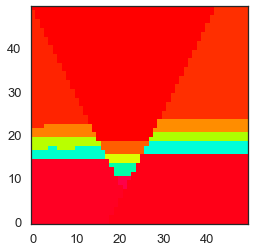

In [20]:
plt.imshow(labels[:, 24, :].T, origin="lower", cmap="hsv")

In [22]:
print("Uniquely labeled all geobodies:", len(np.unique(labels)) == 15)

Uniquely labeled all geobodies: True


In [42]:
diff_z = np.abs(labels[:, :, 1:] + labels[:, :, :-1])
diff_x = np.abs(labels[1:, :, :] + labels[:-1, :, :])
diff_y = np.abs(labels[:, 1:, :] + labels[:, :-1, :])

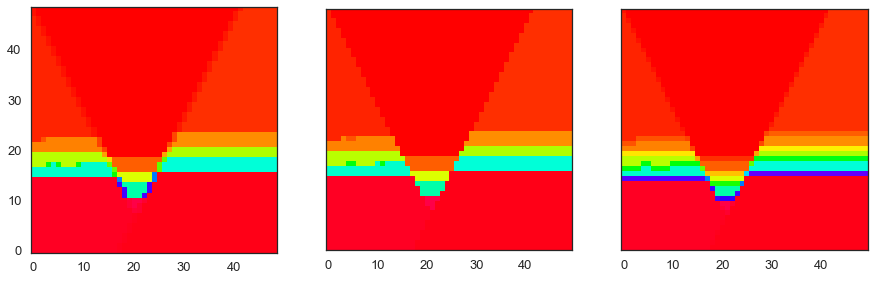

In [44]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, img in zip(axs, [diff_x, diff_y, diff_z]):
    ax.imshow(img[:, 24, :].T, origin="lower", cmap="hsv")

## TODO

* fact check horizon diff uniqueness
* fact check uniqueness of diff across faults
* figure out how to extract topology information from this
    * maybe create a LOT from the unique labels and fault blocks

In [25]:
np.unique(diff_z)

array([ 20,  23,  24,  26,  28,  31,  32,  34,  36,  42,  44,  47,  48,
        52,  58,  60,  68,  74,  76,  87,  88, 100, 106, 108, 132, 138,
       140, 152, 167, 168, 196, 199, 200, 202, 204, 260, 263, 264, 266,
       267, 268], dtype=int64)

In [26]:
len(diff_z)

50

In [27]:
np.unique(labels)

array([ 10,  13,  14,  18,  21,  22,  34,  37,  38,  66,  69,  70, 130,
       133, 134], dtype=int64)

In [28]:
for label in np.unique(labels):
    binary = np.binary_repr(label)
    print(binary, "->", int(binary, 2))

1010 -> 10
1101 -> 13
1110 -> 14
10010 -> 18
10101 -> 21
10110 -> 22
100010 -> 34
100101 -> 37
100110 -> 38
1000010 -> 66
1000101 -> 69
1000110 -> 70
10000010 -> 130
10000101 -> 133
10000110 -> 134


In [29]:
for edge in np.unique(diff_z):
    binary = np.binary_repr(edge)
    print(binary, "->", int(binary, 2))

10100 -> 20
10111 -> 23
11000 -> 24
11010 -> 26
11100 -> 28
11111 -> 31
100000 -> 32
100010 -> 34
100100 -> 36
101010 -> 42
101100 -> 44
101111 -> 47
110000 -> 48
110100 -> 52
111010 -> 58
111100 -> 60
1000100 -> 68
1001010 -> 74
1001100 -> 76
1010111 -> 87
1011000 -> 88
1100100 -> 100
1101010 -> 106
1101100 -> 108
10000100 -> 132
10001010 -> 138
10001100 -> 140
10011000 -> 152
10100111 -> 167
10101000 -> 168
11000100 -> 196
11000111 -> 199
11001000 -> 200
11001010 -> 202
11001100 -> 204
100000100 -> 260
100000111 -> 263
100001000 -> 264
100001010 -> 266
100001011 -> 267
100001100 -> 268
